In [196]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from scipy.ndimage import grey_dilation

In [197]:
#vamos aprende ler uma colecao de figuras

#Listar arquivos .png na pasta atual
current_directory = os.getcwd()+"/figuras/"

event_files=[[f for f in os.listdir(current_directory) if (f.endswith('.png') and ("event" in f) and ("nue" in f) and ("plane_"+str(i) in f))]
              for i in range(3)]
for i in range(3):
    event_files[i]=sorted(event_files[i])

hit_files=[[f for f in os.listdir(current_directory) if (f.endswith('.png') and ("hit" in f) and ("nue" in f) and ("plane_"+str(i) in f))]
              for i in range(3)]
for i in range(3):
    hit_files[i]=sorted(hit_files[i])

In [198]:
event_files

[['nue_WithWire_00_event_5127_137_6863_plane_0.png',
  'nue_WithWire_00_event_5127_137_6866_plane_0.png',
  'nue_WithWire_00_event_5127_137_6867_plane_0.png',
  'nue_WithWire_00_event_5127_137_6870_plane_0.png',
  'nue_WithWire_00_event_5127_137_6875_plane_0.png',
  'nue_WithWire_00_event_5127_138_6908_plane_0.png',
  'nue_WithWire_00_event_5127_138_6910_plane_0.png',
  'nue_WithWire_00_event_5127_138_6928_plane_0.png',
  'nue_WithWire_00_event_5127_138_6938_plane_0.png',
  'nue_WithWire_00_event_5127_139_6951_plane_0.png',
  'nue_WithWire_00_event_5127_139_6980_plane_0.png',
  'nue_WithWire_00_event_5127_139_6986_plane_0.png',
  'nue_WithWire_00_event_5127_139_6988_plane_0.png',
  'nue_WithWire_00_event_5127_139_6991_plane_0.png',
  'nue_WithWire_00_event_5127_140_7007_plane_0.png',
  'nue_WithWire_00_event_5127_140_7029_plane_0.png',
  'nue_WithWire_00_event_5127_140_7041_plane_0.png',
  'nue_WithWire_00_event_5127_141_7078_plane_0.png',
  'nue_WithWire_00_event_5127_141_7091_plane_0

In [199]:
#selecionando figuras aleatorias

n_figuras=1000
n_total=len(event_files[0])

random=np.random.choice(n_total,n_figuras,replace=False)

x=[[] for _ in range(n_figuras)]
y=[[] for _ in range(n_figuras)]

#x_end=128#188
#y_end=512#610

structure = np.ones((3, 3), dtype=np.uint8)  # Elemento estruturante 3x3

for j in range(n_figuras):
    for index in range(3):
        x[j].append(np.divide(grey_dilation(np.array(Image.open(current_directory+event_files[index][random[j]]).convert('L'), dtype=np.uint8),footprint=structure),215))
        y[j].append(np.divide(np.array(Image.open(current_directory+hit_files[index][random[j]]).convert('L')),215))

In [200]:
#deixando a saida binaria
for j in range(n_figuras):
    for i in range(3):
        y[j][i][(y[j][i] > 0.7)] = 1
        y[j][i][~((y[j][i] > 0.7) )] = 0 

In [201]:
#arrumando as dimennsoes da terceira imagem

from scipy.ndimage import zoom
new_matrix = np.zeros((271, 610))
for j in range(n_figuras):
    x[j][2]=zoom(x[j][2],(271.0/188.0,1.0))
    y[j][2]=zoom(y[j][2],(271.0/188.0,1.0))

#deixando a saida binaria
for j in range(n_figuras):
    y[j][2][(y[j][2] > 0.5)] = 1
    y[j][2][~((y[j][2] > 0.5) )] = 0 


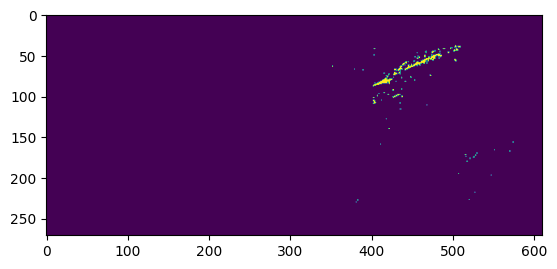

In [208]:
plt.imshow(y[104][1])

In [143]:
len(x[0][2])

165310

In [138]:
#separando em treino e teste dados

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)
#x_train,x_test,y_train,y_test = train_test_split(x,x_teste,random_state=42)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)


""" x_train = x_train.reshape((-1, x_end,y_end, 1))
x_test = x_test.reshape((-1, x_end,y_end, 1))
y_train = y_train.reshape((-1, x_end,y_end, 1))
y_test = y_test.reshape((-1, x_end,y_end, 1))
 """
#x=None

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (750, 3) + inhomogeneous part.